# Proyek Klasifikasi Gambar: [masoudnickparvar/brain-tumor-mri-dataset]
- **Nama:** [Cindy Shafira Dewi]
- **Email:** [cindyfira02@gmail.com]
- **ID Dicoding:** [viracindyyz]

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(tf.__version__)

2.15.0


## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cylevire","key":"e9cfd904ca98d557fda144211bace000"}'}

### Data Preprocessing

#### Split Dataset

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [4]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "Training"
test_dir = "Testing"

# Direktori baru untuk dataset gabungan
combined_dir = "testtrain/dataset"

# Folder yang ingin diambil dari train dan test
train_folders = ['notumor', 'pituitary']
test_folders = ['notumor', 'pituitary']

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin folder yang diinginkan dari train (notumor, pituitary) ke combined_dir
for folder in train_folders:
    category_dir = os.path.join(train_dir, folder)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, folder), dirs_exist_ok=True)

# Salin folder yang diinginkan dari test (notumor, pituitary) ke combined_dir
for folder in test_folders:
    category_dir = os.path.join(test_dir, folder)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, folder), dirs_exist_ok=True)

print("Folder notumor dan pituitary dari folder Training dan Testing telah berhasil digabungkan.")

Folder notumor dan pituitary dari folder Training dan Testing telah berhasil digabungkan.


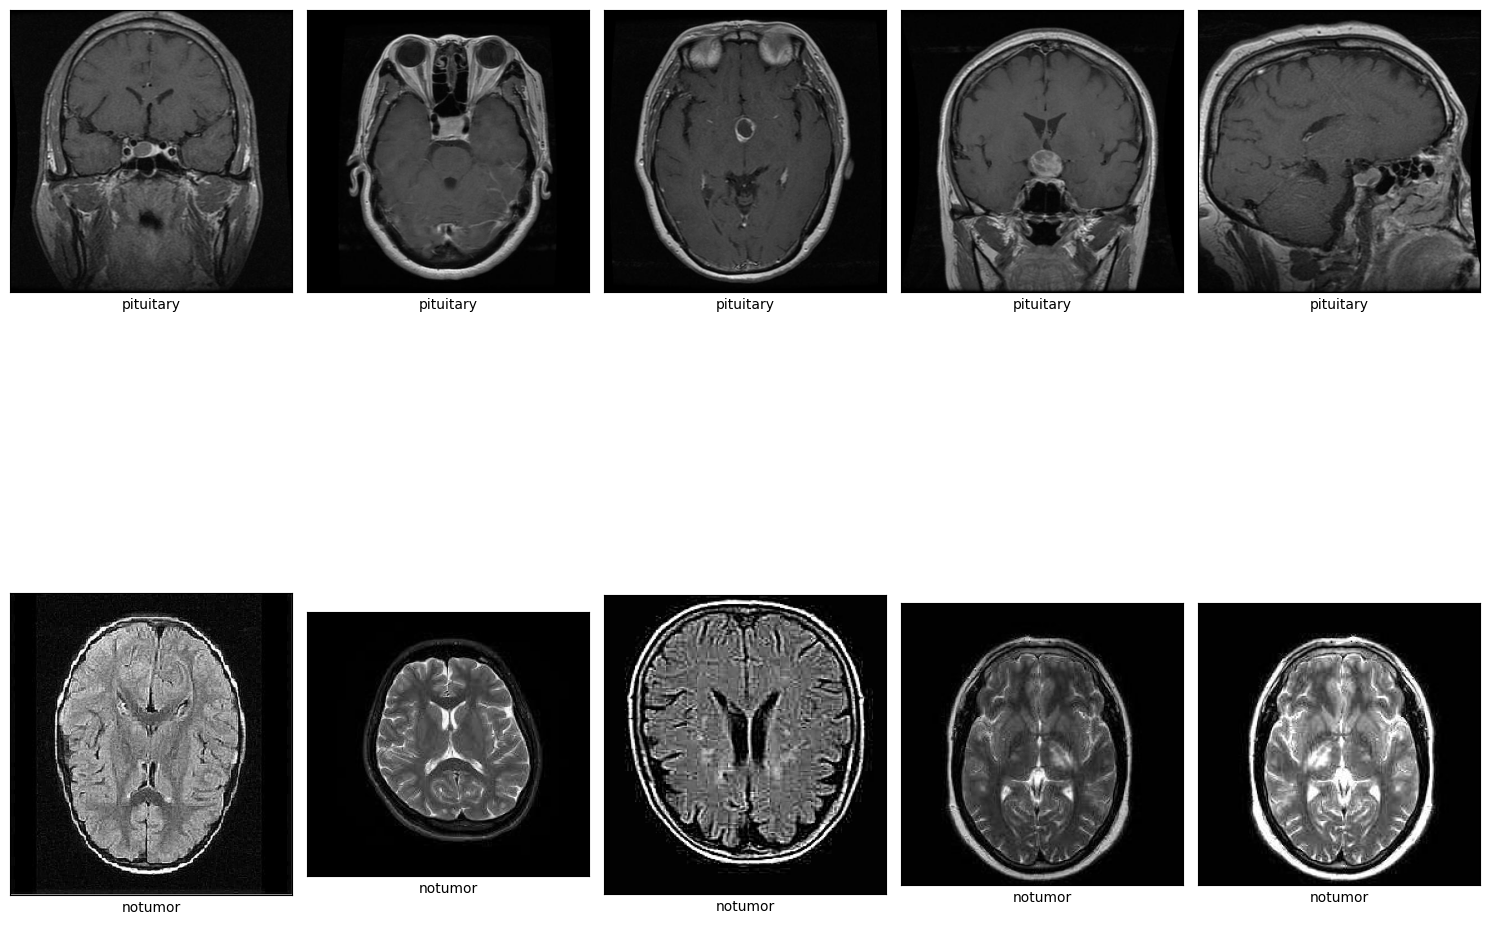

In [5]:
import matplotlib.pyplot as plt

lung_image = {}

# Tentukan path sumber train
path = "testtrain/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "testtrain/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

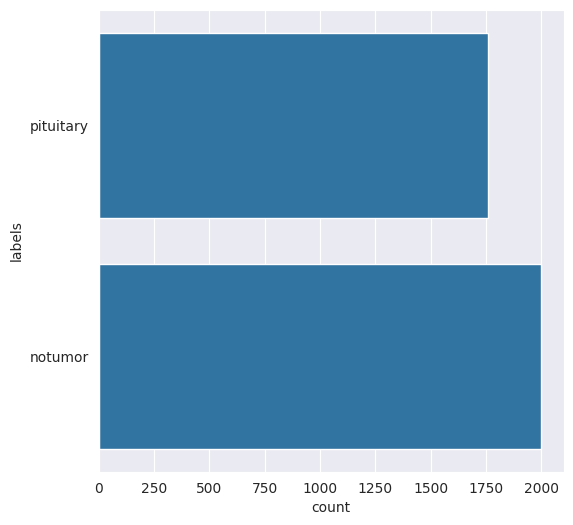

In [6]:
import seaborn as sns

# Definisikan path sumber
lung_path = "testtrain/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [7]:
import os
mypath = 'testtrain/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Hitung jumlah data per label
count_per_label = df.groupby('labels').size()

# Inisialisasi list untuk training dan testing data
X_train = []
y_train = []
X_test = []
y_test = []

# Melakukan pembagian untuk setiap label
for label, count in count_per_label.items():
    # Tentukan jumlah yang diinginkan untuk training dan testing
    train_count = 2526 // len(count_per_label)
    test_count = 631 // len(count_per_label)

    # Ambil data berdasarkan label
    label_data = df[df['labels'] == label]

    # Pastikan kita tidak melebihi jumlah yang ada
    actual_train_count = min(train_count, len(label_data))
    actual_test_count = min(test_count, len(label_data) - actual_train_count)

    # Pisahkan data
    X_train.extend(label_data['path'].iloc[:actual_train_count].tolist())
    y_train.extend(label_data['labels'].iloc[:actual_train_count].tolist())
    X_test.extend(label_data['path'].iloc[actual_train_count:actual_train_count + actual_test_count].tolist())
    y_test.extend(label_data['labels'].iloc[actual_train_count:actual_train_count + actual_test_count].tolist())

# Gabungkan ke dalam DataFrame
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'Training'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'Testing'})

# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "testtrain/dataset/"
dataset_path = "Dataset-Final/"

for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'].split('.')[0])

    # Buat direktori tujuan folder
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']), exist_ok=True)

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

    # Salin file dari sumber ke tujuan
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/Training/"
TEST_DIR = "Dataset-Final/Testing/"

train_notumor = os.path.join(TRAIN_DIR, 'notumor')
train_pituitary = os.path.join(TRAIN_DIR, 'pituitary')
test_notumor = os.path.join(TEST_DIR, 'notumor')
test_pituitary = os.path.join(TEST_DIR, 'pituitary')

print("Total number of notumor images in training set: ", len(os.listdir(train_notumor)))
print("Total number of pituitary images in training set: ", len(os.listdir(train_pituitary)))
print("Total number of notumor images in test set: ", len(os.listdir(test_notumor)))
print("Total number of pituitary images in test set: ", len(os.listdir(test_pituitary)))


set       labels   
Testing   notumor       315
          pituitary     315
Training  notumor      1263
          pituitary    1263
dtype: int64 


                                            path     labels       set
987     testtrain/dataset/notumor/Te-no_0077.jpg    notumor  Training
2445  testtrain/dataset/pituitary/Tr-pi_0716.jpg  pituitary  Training
491     testtrain/dataset/notumor/Tr-no_0579.jpg    notumor  Training
292     testtrain/dataset/notumor/Tr-no_1269.jpg    notumor  Training
1828  testtrain/dataset/pituitary/Tr-pi_1277.jpg  pituitary  Training


0it [00:00, ?it/s]

Total number of notumor images in training set:  1263
Total number of pituitary images in training set:  1263
Total number of notumor images in test set:  315
Total number of pituitary images in test set:  315


In [8]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              shuffle=True)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 2526 images belonging to 2 classes.
Found 630 images belonging to 2 classes.


## Modelling

In [9]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 32)        128       
 chNormalization)                                                
                                                        

In [10]:
count_notumor, count_pituitary = len(os.listdir(train_notumor)), len(os.listdir(train_pituitary))
weight_0 = (1 / count_notumor) * (count_notumor + count_pituitary) / 2.0
weight_1 = (1 / count_pituitary) * (count_pituitary + count_notumor) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=20,
                        batch_size=32,
                        validation_data=test_generator,
                        class_weight = class_weights)

CPU times: user 25 µs, sys: 18 µs, total: 43 µs
Wall time: 88.2 µs
Epoch 1/20
79/79 [==============================] - 26s 310ms/step - loss: 0.5128 - accuracy: 0.8923 - val_loss: 0.4980 - val_accuracy: 0.7651
Epoch 2/20
79/79 [==============================] - 24s 306ms/step - loss: 0.2069 - accuracy: 0.9477 - val_loss: 0.3996 - val_accuracy: 0.8381
Epoch 3/20
79/79 [==============================] - 24s 309ms/step - loss: 0.1459 - accuracy: 0.9679 - val_loss: 0.4270 - val_accuracy: 0.8619
Epoch 4/20
79/79 [==============================] - 24s 309ms/step - loss: 0.1378 - accuracy: 0.9747 - val_loss: 1.4623 - val_accuracy: 0.7571
Epoch 5/20
79/79 [==============================] - 24s 309ms/step - loss: 0.0886 - accuracy: 0.9857 - val_loss: 0.4406 - val_accuracy: 0.8905
Epoch 6/20
79/79 [==============================] - 24s 308ms/step - loss: 0.0408 - accuracy: 0.9893 - val_loss: 0.0910 - val_accuracy: 0.9635
Epoch 7/20
79/79 [==============================] - 24s 306ms/step - loss: 

In [11]:
# Mencetak akurasi training dan validasi
print("Akurasi Training: {:.2f}%".format(history_1.history['accuracy'][-1] * 100))
print("Akurasi Validasi: {:.2f}%".format(history_1.history['val_accuracy'][-1] * 100))

Akurasi Training: 99.84%
Akurasi Validasi: 99.68%


## Evaluasi dan Visualisasi

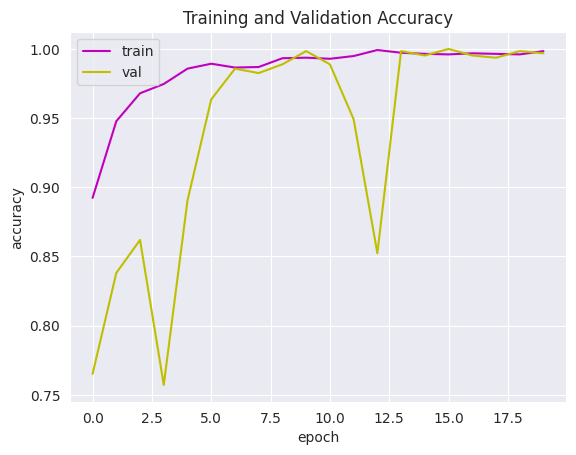

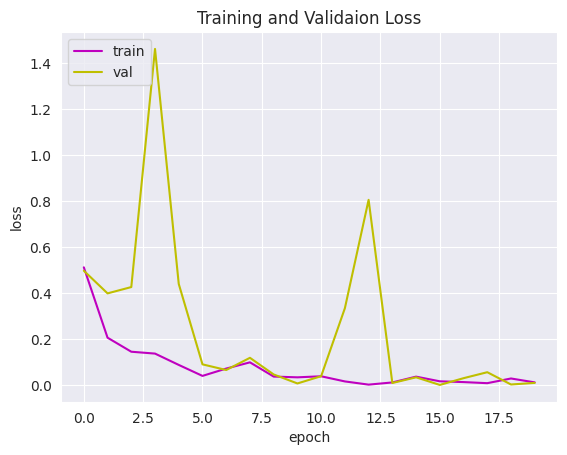

In [12]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'm')
plt.plot(epochs, val_acc, 'y')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'm')
plt.plot(epochs, val_loss, 'y')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

     Notumor     1.0000    0.9937    0.9968       315
   Pituitary     0.9937    1.0000    0.9968       315

    accuracy                         0.9968       630
   macro avg     0.9968    0.9968    0.9968       630
weighted avg     0.9968    0.9968    0.9968       630



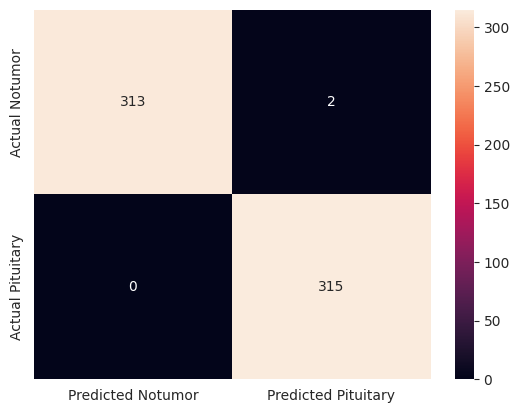

In [13]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Notumor", "Actual Pituitary"],
columns=["Predicted Notumor", "Predicted Pituitary"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Notumor','Pituitary'], digits=4))

## Konversi Model

In [14]:
# Menyimpan model dalam format SavedModel
model_1.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='conv2d_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137761801056352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761801058288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761801059520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761749305472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761749306704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761749307936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761801056528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761749309872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761749313040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761749309168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137761749315152: Te

In [15]:
import os

# Cek apakah folder saved_model dan isinya ada
if os.path.exists('saved_model'):
    print("Model saved in 'saved_model' folder.")
    print("Contents of 'saved_model':", os.listdir('saved_model'))
else:
    print("Model not saved.")

Model saved in 'saved_model' folder.
Contents of 'saved_model': ['fingerprint.pb', 'saved_model.pb', 'variables', 'assets']


In [16]:
import shutil
from google.colab import files

# Misalkan Anda sudah menyimpan model dalam folder 'saved_model'
saved_model_dir = 'saved_model'

# Zip folder SavedModel
shutil.make_archive(saved_model_dir, 'zip', saved_model_dir)

# Unduh file zip yang telah dibuat
files.download(f'{saved_model_dir}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import tensorflow as tf
import os

# Cek isi direktori saat ini
print("Contents of current directory:", os.listdir('.'))

# Langkah 1: Mengonversi model ke format TFLite
try:
    converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')  # Ganti dengan path model yang sesuai
    tflite_model = converter.convert()
    print("Model successfully converted to TFLite.")

    # Menyimpan model TFLite ke file
    with open('model.tflite', 'wb') as f:
        f.write(tflite_model)
    print("TFLite model saved as 'model.tflite'.")
except Exception as e:
    print("Error during TFLite conversion:", e)

# Langkah 2: Menyimpan label ke dalam file
labels = ['Notumor', 'Pituitary']  # Sesuaikan dengan label kelas yang digunakan

try:
    with open('label.txt', 'w') as f:
        for label in labels:
            f.write(label + '\n')
    print("Labels saved as 'label.txt'.")
except Exception as e:
    print("Error while saving labels:", e)

Contents of current directory: ['.config', 'Training', 'saved_model.zip', 'brain-tumor-mri-dataset.zip', 'testtrain', 'saved_model', 'Testing', 'kaggle.json', 'Dataset-Final', 'sample_data']
Model successfully converted to TFLite.
TFLite model saved as 'model.tflite'.
Labels saved as 'label.txt'.


In [18]:
import shutil
from google.colab import files

# Nama file TFLite
tflite_file = 'model.tflite'

# Zip file TFLite
shutil.make_archive('model_tflite', 'zip', '.', tflite_file)

# Unduh file zip yang telah dibuat
files.download('model_tflite.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
pip install tensorflow==2.17.0

In [26]:
pip install tensorflow-decision-forests

In [28]:
model_1.save("model.h5")

In [29]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-09-22 16:18:43.134733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 16:18:43.154679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 16:18:43.160452: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 16:18:44.137765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [30]:
import os
import shutil

# Buat folder untuk menyimpan hasil konversi model
output_folder = 'tfjs_model'
os.makedirs(output_folder, exist_ok=True)

# Zip folder untuk diunduh
shutil.make_archive(output_folder, 'zip', output_folder)

# Link untuk mengunduh
from google.colab import files
files.download(f'{output_folder}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
 pip freeze requirements.txt

absl-py==1.4.0
accelerate==0.34.2
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
astunparse==1.6.3
attrs==24.2.0
audioread==3.0.1
backcall==0.2.0
beautifulsoup4==4.12.3
bleach==6.1.0
blinker==1.4
blis==0.7.11
build==1.2.2
cachetools==5.5.0
catalogue==2.0.10
certifi==2024.8.30
cffi==1.17.1
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
cloud-tpu-client==0.10
cloudpathlib==0.19.0
cloudpickle==3.0.0
confection==0.1.5
contourpy==1.3.0
cryptography==3.4.8
cycler==0.12.1
cymem==2.0.8
dbus-python==1.2.18
debugpy==1.6.6
decorator==5.1.1
defusedxml==0.7.1
distrax==0.1.5
distro==1.7.0
dm-tree==0.1.8
docstring_parser==0.16
dopamine_rl==4.0.9
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl#sha256=86cc141f63942d4b2c5fcee06630fd6f904788d2f0ab005cce45aadb8fb73889
entrypoints==0.4
etils==1.9.4
exceptiongroup==1.2.2
fastai==2.7.17
fastcore=

## Inference (Optional)